# RL for Channel Selection
## Top-level simulation script

## Define functions to allow importing from Jupyter notebooks
Ref: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html

NB: This code should be moved to a utility library.

In [1]:
import io, os, sys, types
from IPython import get_ipython
from Utils import NotebookFinder
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import matplotlib.pyplot as plt

sys.meta_path.append(NotebookFinder())

In [2]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]
    
sys.meta_path.append(NotebookFinder())

## Utility functions

In [3]:
def null(*args):
    pass

def setDbgPrint(dbgPrint):
    if type(dbgPrint) == str:
        dbgPrint = eval(dbgPrint)
        
    if dbgPrint is None or dbgPrint in ['', {}]:
        dbgPrint = lambda *args: None
    
    return dbgPrint

def printPeriodic(*args, **kwargs):
    """Print periodically per optional arguments 'period' & 'counter' when 'counter % period == 0',
       else print normally.
    """
    period = None
    if 'period' in kwargs:
        period = kwargs.pop('period')
    
    counter = None
    if 'counter' in kwargs:
        counter = kwargs.pop('counter')
    
    isPrint = True
    if counter and period:
        if counter % period != 0:
            isPrint = False
    
    if isPrint:
        print(*args, **kwargs)

## Begin main simulation run script.

In [4]:
from env import Env
from RL_brain import DeepQNetwork

importing Jupyter notebook from env.ipynb
importing Jupyter notebook from data_Generator.ipynb
importing Jupyter notebook from RL_brain.ipynb


## Simulation configuration parameters

In [5]:
sim = {
    'cfg' : {
        'run' : { # run parameters
            'numEpisodes'    : 1, # 1,        # num. of episodes to run
            'maxSteps'       : 10000,         # max. num. of sim. steps
            'startLearnStep' : 200,           # start periodic training after this step num.
            'learnPeriod'    : 5,             # num. of steps between (re)training
            'dbgPrint'       : printPeriodic, # function or string name of function for debug print output
            'statusPeriod'   : 100,           # output program status at this interval
        },
        'dqn' : { # DQN parameters
            'learningRate'      : 0.01, # please provide summary comments for each parameter
            'rewardDecay'       : 0.9,      
            'eGreedy'           : 1,
            'eGreedyincrement'  : 0.005, # Change the e_greedy value
            'replaceTargetIter' : 200,
            'memorySize'        : 2000,
        }
    }
}


## The run() command runs the main simulation loop.

In [6]:
def run(cfg=None):
    # For ease of access to run parameters.
    step = 0
    numEpisodes = cfg['numEpisodes']
    maxSteps = cfg['maxSteps']
    startLearnStep = cfg['startLearnStep']
    learnPeriod = cfg.get('learnPeriod', 5)
    dbgPrint = cfg.get('dbgPrint', null)
    statusPeriod = cfg.get('statusPeriod', 1)
    
    for episode in range(1,numEpisodes+1):
        # initial observation
        step = 0
        env_state_1 = env.reset()
        env.count_history = []
        while step < maxSteps:
            # fresh env

            # Output current observation:
            #print('{}: current env = {}\n'.format(env.time, env.__dict__))
            dbgPrint('{}: current env = {}\n'.format(env.time,env.time_env_state), period=statusPeriod, counter=env.time)

            env_state = np.hstack((env_state_1["Channel_1"], env_state_1["Channel_6"],
                                   env_state_1["Channel_11"]))
            # RL choose action based on env_state

            action = RL.choose_action(env_state)
            if action == 0:
                action_ = "Channel_1"
            elif action == 1:
                action_ = "Channel_6"
            else:
                action_ = "Channel_11"
            observation = env_state_1[action_]

            dbgPrint('{}: action_ = {}, observation = {}\n'.format(env.time, action_, observation), period=statusPeriod, counter=env.time)
            # print(observation)
            # RL take action and get next observation and reward
            env_state_, observation_, reward = env.step(action_)
            env_state_ = np.hstack(( env_state_["Channel_1"],  env_state_["Channel_6"],
                                      env_state_["Channel_11"]))


            RL.store_transition(env_state, action, reward, env_state_)

            if (step > startLearnStep) and (step % learnPeriod == 0):
                RL.learn()
            env_state_={"Channel_1":env_state_[0:1],
                        "Channel_6":env_state_[1:2],
                        "Channel_11":env_state_[2:3]

            }

            # swap observation
            #observation = observation_
            env_state_1 = env_state_

            # break while loop when end of this episode
            step += 1

## Main simulation routine

In [7]:
if __name__ == "__main__":
    # For ease of access to env config. parameters.
    statusPeriod = sim['cfg']['run']['statusPeriod']
    dbgPrint = setDbgPrint(sim['cfg']['run'].get('dbgPrint'))

    # Init. environment.
    env = Env(log=dbgPrint, statusPeriod=statusPeriod)
    
    # For ease of access to DQN config. parameters.
    learningRate = sim['cfg']['dqn']['learningRate']
    rewardDecay = sim['cfg']['dqn']['rewardDecay']
    eGreedy = sim['cfg']['dqn']['eGreedy']
    e_greedy_increment = sim['cfg']['dqn']['eGreedyincrement']
    replaceTargetIter = sim['cfg']['dqn']['replaceTargetIter']
    rewardDecay = sim['cfg']['dqn']['learningRate']    
    memorySize = sim['cfg']['dqn']['memorySize']
    
    RL = DeepQNetwork(n_actions=env.n_actions,
                      n_features=env.n_features,
                      learning_rate=learningRate,
                      reward_decay=rewardDecay,
                      e_greedy=eGreedy,
                      replace_target_iter=replaceTargetIter,
                      e_greedy_increment = e_greedy_increment,
                      memory_size=memorySize,
                      dbgPrint=dbgPrint,
                      statusPeriod=statusPeriod
                      )
    #    env.data()
    run(cfg=sim['cfg']['run'])

Instructions for updating:
Colocations handled automatically by placer.
200: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

200: action_ = Channel_11, observation = [0.99605735]

200: action  has min. value inf

1300: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

1300: action_ = Channel_6, observation = [0.5]

1300: action  has min. value inf


target_params_replaced

2400: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

2400: action_ = Channel_6, observation = [0.5]

2400: action  has min. value inf

3500: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

3500: action_ = Channel_11, observation = [0.99605735]

3500: action  has min. value inf

4600: current env = {'current': {'Chan

40900: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

40900: action_ = Channel_6, observation = [0.5]

40900: action  has min. value inf

42000: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

42000: action_ = Channel_6, observation = [0.5]

42000: action  has min. value inf

43100: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

43100: action_ = Channel_6, observation = [0.5]

43100: action  has min. value inf

44200: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

44200: action_ = Channel_6, observation = [0.5]

44200: action  has min. value inf

45300: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

4530

83800: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

83800: action_ = Channel_6, observation = [0.5]

83800: action  has min. value inf

84900: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

84900: action_ = Channel_6, observation = [0.5]

84900: action  has min. value inf

86000: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

86000: action_ = Channel_6, observation = [0.5]

86000: action  has min. value inf

87100: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

87100: action_ = Channel_6, observation = [0.5]

87100: action  has min. value inf

88200: current env = {'current': {'Channel_1': array([0.43733338]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

8820

<IPython.core.display.Javascript object>


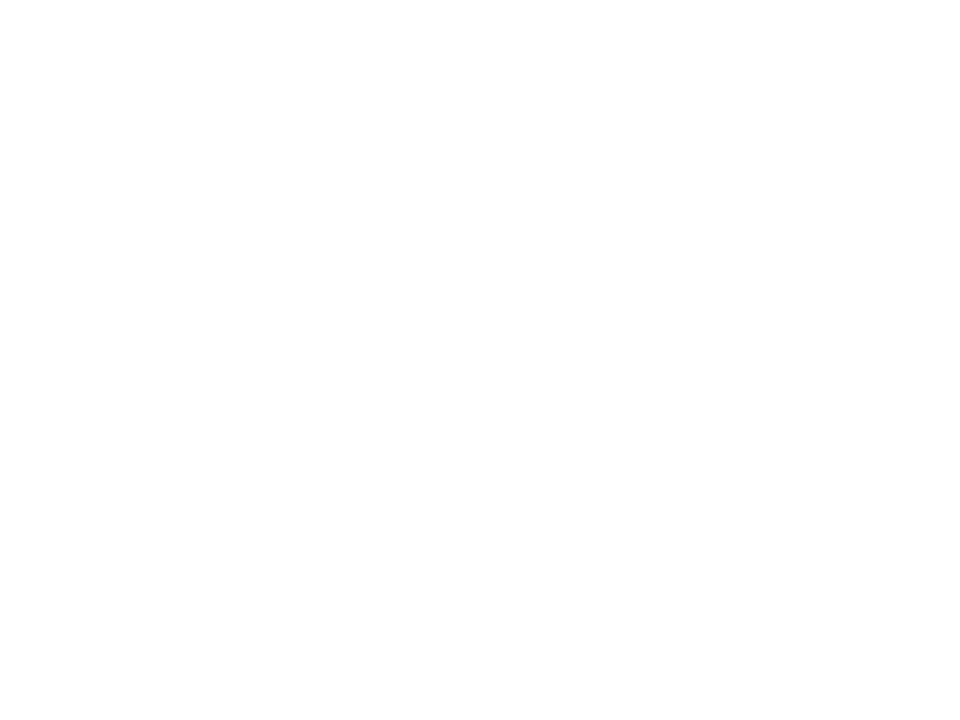

cost_hist's Length is 1959


In [8]:
# allow use of interactive plot controls, e.g., zoom
%matplotlib notebook
get_ipython().run_line_magic('matplotlib', 'notebook')
RL_plot_cost = RL.plot_cost()
RL_plot_cost.gca().grid(True)

<IPython.core.display.Javascript object>


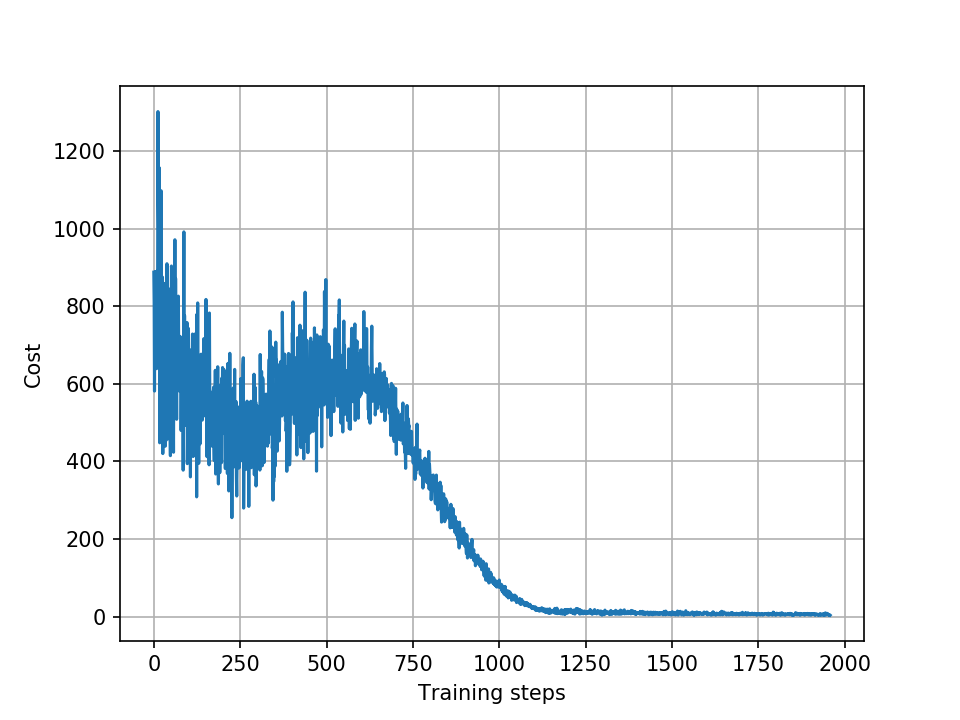

cost_hist's Length is 1959


<IPython.core.display.Javascript object>


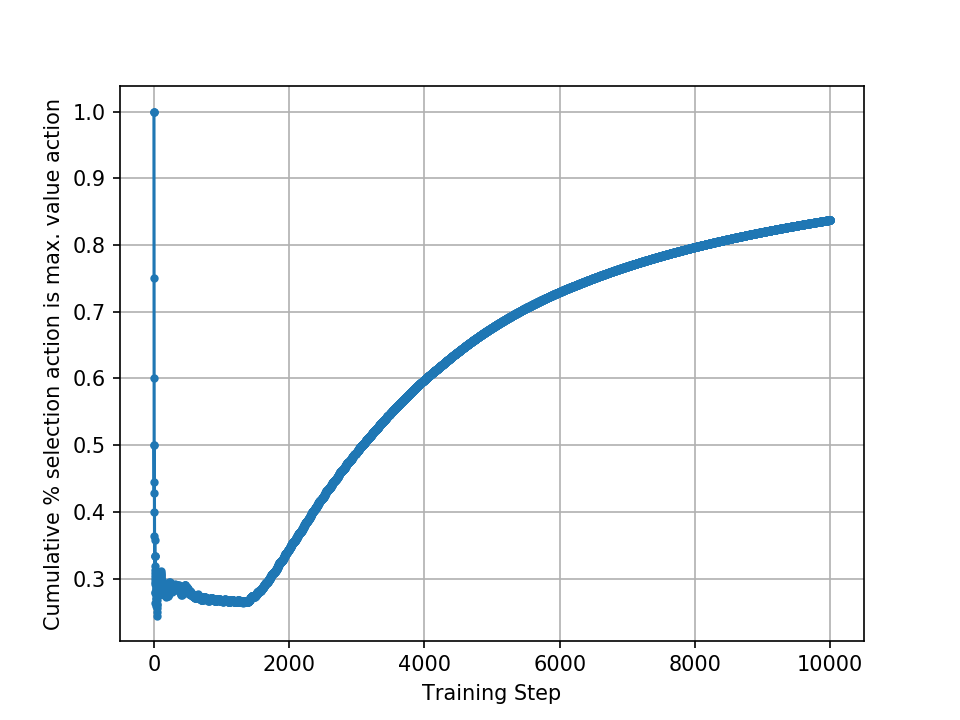

In [9]:
# allow use of interactive plot controls, e.g., zoom
get_ipython().run_line_magic('matplotlib', 'notebook')
RL_plot_cost = RL.plot_cost()
RL_plot_cost.gca().grid(True)


# In[ ]:


# allow use of interactive plot controls, e.g., zoom
#get_ipython().run_line_magic('matplotlib', 'notebook')
# env.plot_count()
plt.figure()
plt.plot(

    np.divide( np.cumsum([1 if i >= 50 else 0 for i in env.count_history]), np.arange(len(env.count_history)) + 1),
    '.-')
plt.xlabel('Training Step')
plt.ylabel('Cumulative % selection action is max. value action')
plt.grid(True)
plt.show()